# Training and forecast example of an automated ARIMA model (TBATS).

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from fbprophet import Prophet
from tbats import TBATS


## Load dataset

In [2]:
ts60 = pd.read_csv('../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)
load60 = ts60['Diff Load Activa Total (60 minuto)'].dropna()
load60.head()

datetime
2020-11-06 00:00:00    2600.0
2020-11-06 01:00:00    2610.0
2020-11-06 02:00:00    2570.0
2020-11-06 03:00:00    2580.0
2020-11-06 04:00:00    2600.0
Name: Diff Load Activa Total (60 minuto), dtype: float64

## Seasonality detection
The time series is highly seasonal so this requires some further inspection.

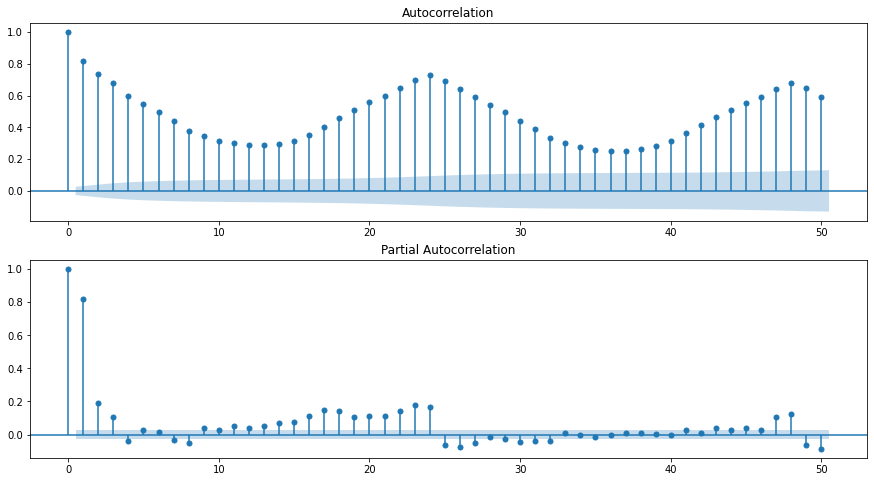

In [3]:
fig, ax = plt.subplots(2,1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(load60, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(load60, lags=50, ax=ax[1])
plt.show()

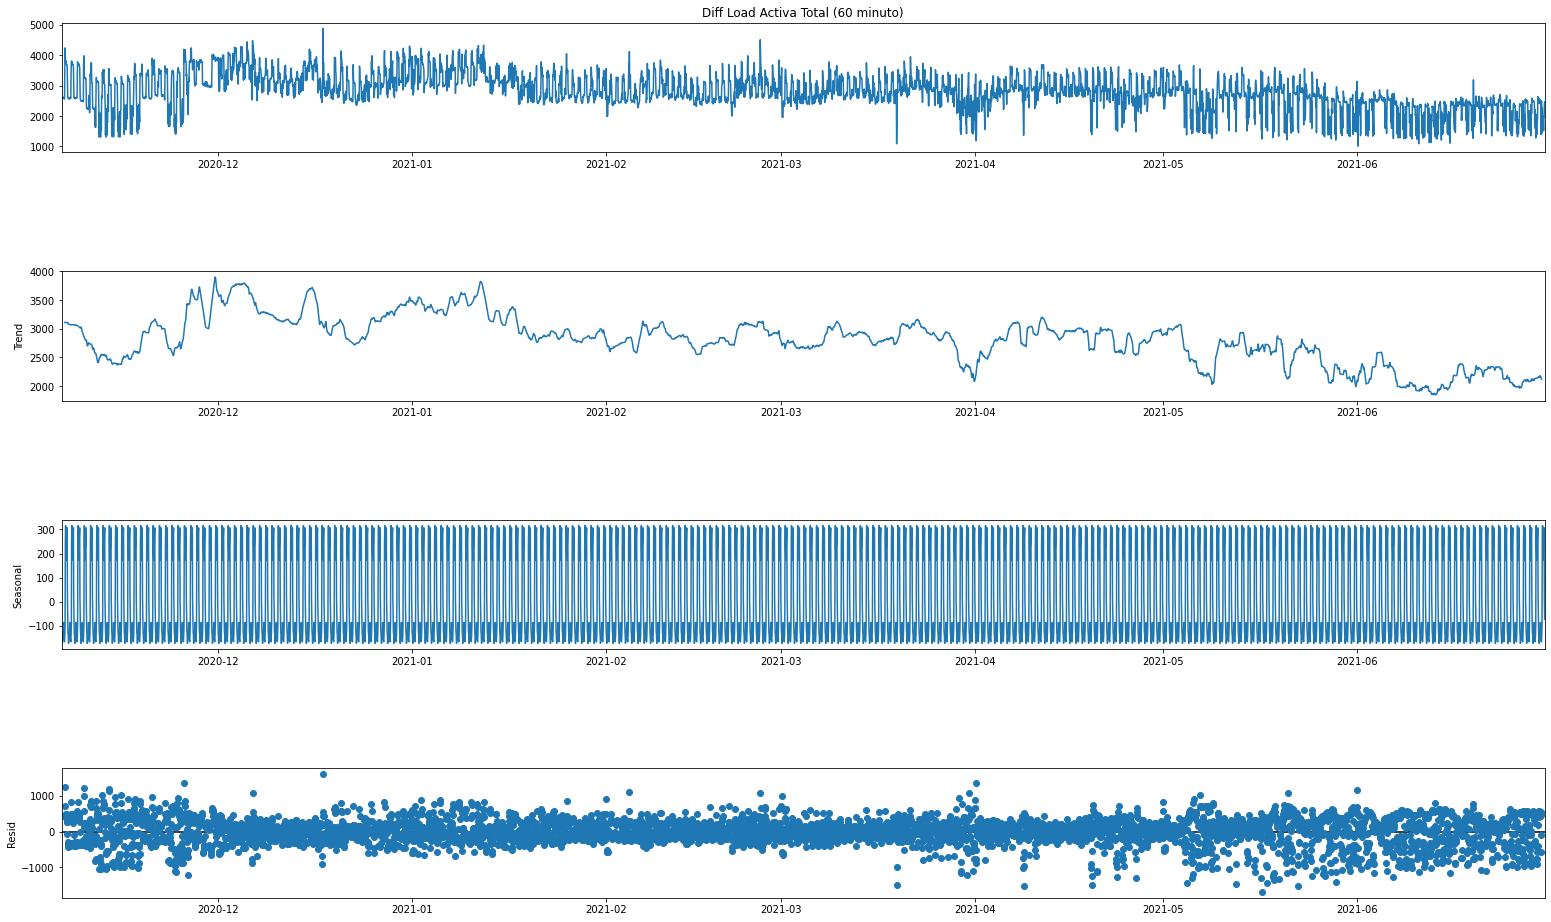

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(load60,  model='additive', period=24)
f = result.plot()
f.set_figheight(15)
f.set_figwidth(25)
plt.show()

Daily seasonality is obvious from all above plots. e.g. ACF is repeated every 24 timesteps. Therefore seasonal models are expected to produce better results.

## Configuration

Steps for day ahead forecasts are preset to 24 (1 day). days_ahead are the number of days to reproduce forecast without retraining.

In [5]:
steps = 24
days_ahead = 11

## Train / test split

In [6]:
last_train_day = datetime(2021, 6, 20)
train = load60[:(last_train_day - timedelta(hours=1))]
train = train.asfreq('H')
test = load60[last_train_day:last_train_day + timedelta(hours=days_ahead*steps-1)]
test = test.asfreq('H')


## Training TBATS
In this section 2 TBATS models are fitted.

### Fit TBATS simple

In [5]:
# Fit the model
estimator = TBATS(seasonal_periods=(24, 168), n_jobs=6)
model = estimator.fit(train)
model.summary()

'Use Box-Cox: False\nUse trend: False\nUse damped trend: False\nSeasonal periods: [ 24. 168.]\nSeasonal harmonics [10  5]\nARMA errors (p, q): (4, 2)\nSmoothing (Alpha): 0.021652\nSeasonal Parameters (Gamma): [-1.11565396e-04  7.22198400e-05  5.02800514e-05 -1.28167751e-07]\nAR coefficients [ 5.02800514e-05 -1.28167751e-07  3.79674737e-01  4.30084121e-02]\nMA coefficients [0.51941709 0.39661608]\nSeed vector [ 2.95533046e+03 -2.22063920e+01 -9.35985599e+01  9.08837773e-01\n -6.03681782e+01  2.57953981e+01 -3.33008740e+00  1.68288787e+01\n  1.82575792e+01 -8.30822706e+00  3.50357295e+00 -2.36974551e+02\n  5.50933246e+00 -4.58600432e+01  3.32089662e+01  3.40215501e+01\n -1.10535597e+01  2.73278089e+01 -8.81188298e+00 -3.81189249e+00\n -1.73453730e+01 -3.25850380e+00 -4.47414591e+00  6.62397206e+00\n -1.31628758e+01 -2.33572461e+00  1.91250836e+01 -7.15409516e-01\n -2.45256706e+00 -1.77681334e+01 -5.07806641e+00  0.00000000e+00\n  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

#### Save model locally

In [ ]:
fname = "../VEOLIA/models/tal_tbats_simple.pkl"  
with open(fname, 'wb') as file:  
    pickle.dump(model, file)

### Fit TBATS complex

In [6]:
# Fit the model
estimator = TBATS(seasonal_periods=(24, 168), n_jobs=6, use_box_cox=True, use_arma_errors=True, use_damped_trend=True, use_trend=True)
model_complex = estimator.fit(train)
model_complex.summary()

'Use Box-Cox: True\nUse trend: True\nUse damped trend: True\nSeasonal periods: [ 24. 168.]\nSeasonal harmonics [10  5]\nARMA errors (p, q): (0, 0)\nBox-Cox Lambda 1.000000\nSmoothing (Alpha): 0.662802\nTrend (Beta): -0.148360\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-1.13053056e-06 -1.87272727e-06  1.85953822e-06  1.44366465e-06]\nAR coefficients []\nMA coefficients []\nSeed vector [ 2.07467248e+03  1.90498596e+02 -2.10261222e+01 -9.31429869e+01\n  1.23127676e+00 -6.00921755e+01  2.60500201e+01 -3.08692366e+00\n  1.70652896e+01  1.84897974e+01 -8.07865862e+00  3.73150140e+00\n -2.36889395e+02  5.55751636e+00 -4.58282792e+01  3.32318863e+01\n  3.40388426e+01 -1.10402644e+01  2.73380135e+01 -8.80419530e+00\n -3.80637566e+00 -1.73418008e+01  5.27051472e+01  7.71075073e+00\n  1.07011037e+01 -8.97289030e+00  2.91082657e-01  2.14772502e+01\n  4.85798398e+00 -1.38026846e+00 -1.72464571e+01 -2.98272615e+00]\n\nAIC 108468.499933'

### Save model locally

In [ ]:
fname = "../VEOLIA/models/tal_tbats_complex.pkl"  
with open(fname, 'wb') as file:  
    pickle.dump(model_complex, file)

## Day ahead forecasts

In [7]:
forecast = model.forecast(steps=steps)
forecast_complex = model_complex.forecast(steps=steps)

### Evaluation

In [8]:
print("Simple model:")
print("MAPE:", mape(test[:steps], forecast[:steps]))
print("MSE:", mse(test[:steps], forecast[:steps]))
print("RMSE:", np.sqrt(mse(test[:steps], forecast[:steps])))

print("Complex model:")
print("MAPE:", mape(test[:steps], forecast_complex[:steps]))
print("MSE:", mse(test[:steps], forecast_complex[:steps]))
print("RMSE:", np.sqrt(mse(test[:steps], forecast_complex[:steps])))

Simple model:
MAPE: 0.15152688326569883
MSE: 149291.02504299566
RMSE: 386.3819678025822
Complex model:
MAPE: 0.15556587841152034
MSE: 151357.02893338352
RMSE: 389.0463069268021


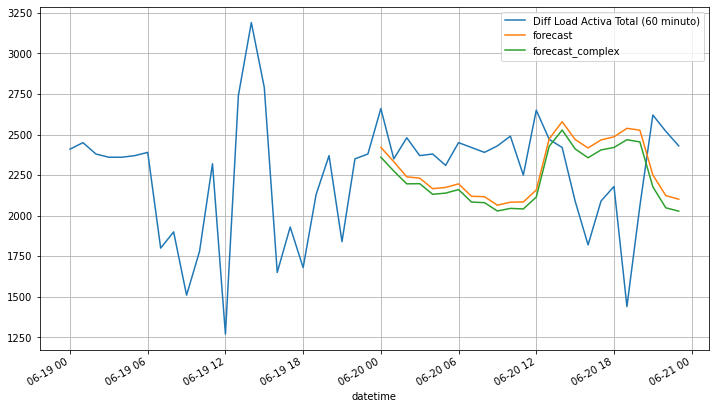

In [9]:
comparison = pd.DataFrame(test[:steps])
comparison['forecast'] = forecast
comparison['forecast_complex'] = forecast_complex
train = pd.DataFrame(train, columns=comparison.filter(like='Diff').columns.tolist())
comparison = pd.concat([train, comparison])
plt = comparison[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

## Training prophet
In this section facebook prophet is trained (supposed to capture seasonality).

In [21]:
# add datetime as column for prophet
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.values
# define the model
model_prophet = Prophet()
# fit the model
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -44.6514


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10483.2    0.00714846       1051.29      0.5763      0.5763      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10505.8    0.00070365       107.255           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244         10510   0.000301393       337.953   6.481e-07       0.001      346  LS failed, Hessian reset 
     299       10514.9   7.44461e-05       73.7932      0.7148      0.7148      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311         10515   9.71775e-05       111.741   1.255e-06       0.001      472  LS failed, Hessian reset 
     399       10517.8    0.00404677       148.263           1           1      574   
    Iter      log prob        ||dx||      ||grad||       alpha

### Save model locally

In [ ]:
fname = "../VEOLIA/models/tal_prophet.pkl"  
with open(fname, 'wb') as file:  
    pickle.dump(model_prophet, file)

### Day-ahead forecast
A day-ahead forecast is produced and evaluated.

MAPE: 0.20372118460747402
MSE: 252530.9324914722
RMSE: 502.52455909285885


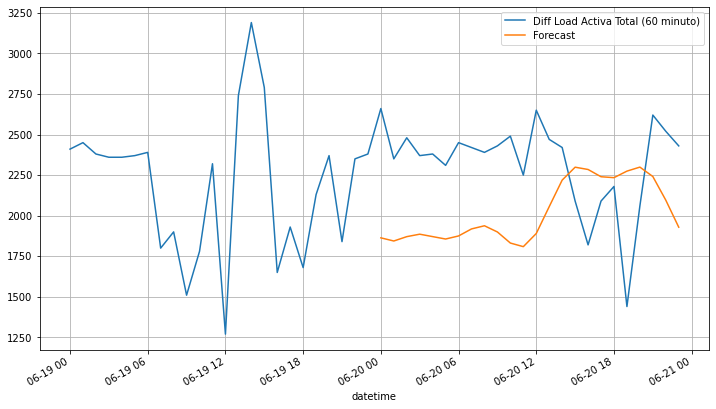

In [55]:
# evaluation
future = pd.DataFrame(test.index[:steps]).rename(columns={'datetime':'ds'})
forecast_prophet = model_prophet.predict(future)
predictions = forecast_prophet['yhat'].values
ground_truth = test[:steps]

print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

# plot forecast
comparison_prophet = pd.DataFrame(ground_truth)
comparison_prophet['Forecast'] = predictions
train = pd.DataFrame(train, columns=comparison_prophet.filter(like='Diff').columns.tolist())
comparison_prophet = pd.concat([train, comparison_prophet])
plt = comparison_prophet[datetime(2021, 6, 19):].plot(figsize=(12,7))
plt.grid()

Prophet is outperformed by TBATS but still results are not satisfying. Therefore we proceed to SARIMA models as described in the R_tal_time_series_analysis.

## Training SARIMA to capture seasonality

### SARIMA model from r gridsearch
A sarima is fitted as selected in the gridsearch process of R_tal_time_series_analysis.ipynb (further analysis can be sought there). However we have limited the seasonal autoregressive terms to 1 for speed and simplicity as longs as the model could not be saved otherwise. AIC, residuals, ACF, PACFs are presented again for completeness.

In [7]:
sarima = sm.tsa.statespace.SARIMAX(endog=train, order=(4, 1, 1),
                                   seasonal_order=(1, 1, 1, 24)).fit(max_iter=50, method='powell')
print(sarima.summary())

Optimization terminated successfully.
         Current function value: 7.048667
         Iterations: 3
         Function evaluations: 285
                                       SARIMAX Results                                        
Dep. Variable:     Diff Load Activa Total (60 minuto)   No. Observations:                 5424
Model:                 SARIMAX(4, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -38231.968
Date:                                Fri, 23 Jul 2021   AIC                          76479.936
Time:                                        07:23:48   BIC                          76532.688
Sample:                                    11-06-2020   HQIC                         76498.353
                                         - 06-19-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

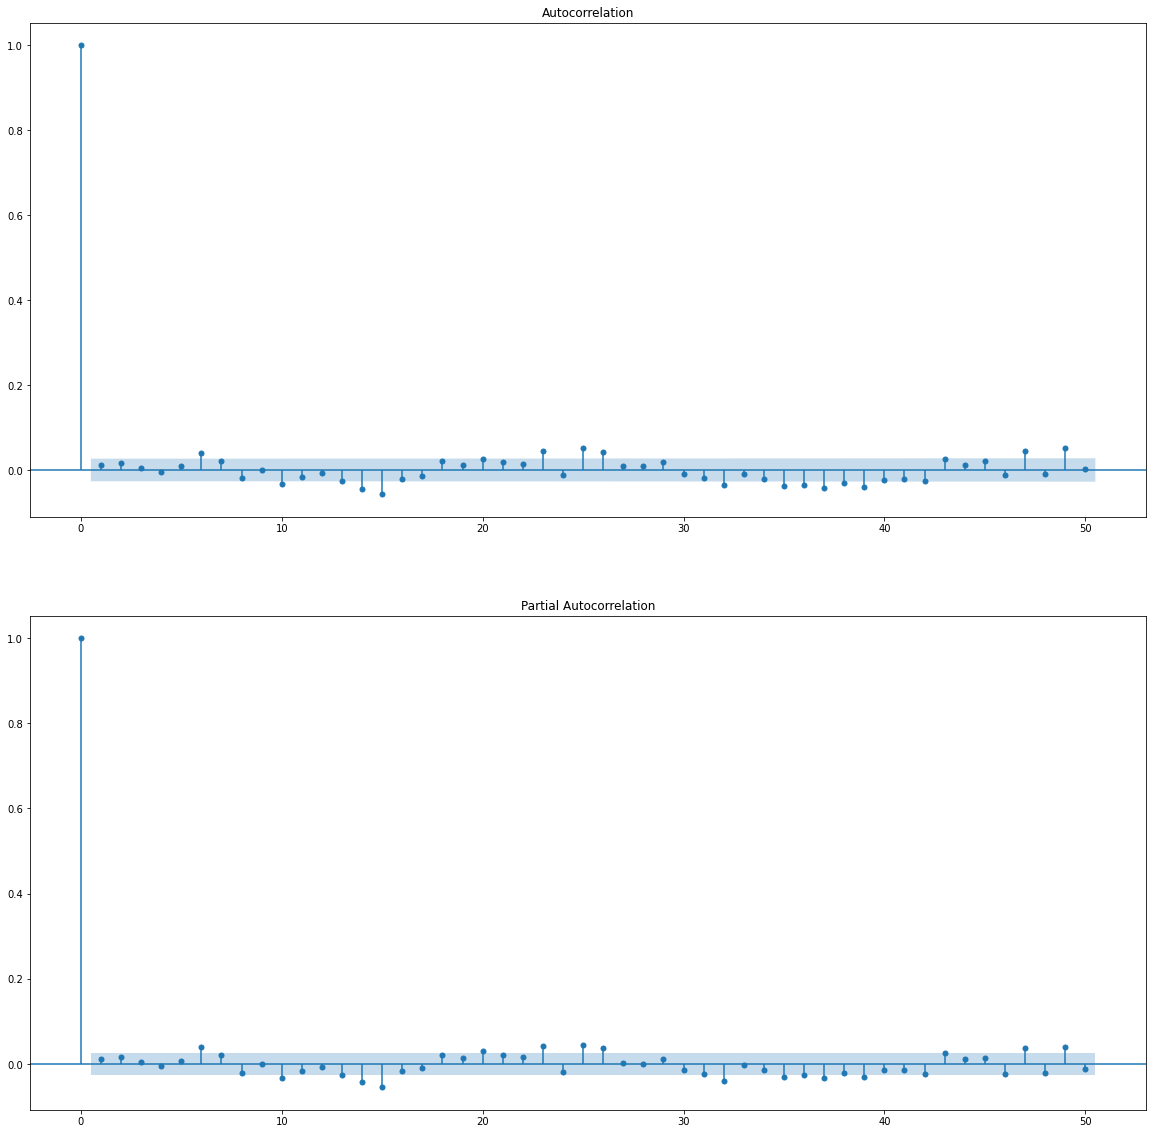

In [8]:
res = sarima.resid
fig, ax = plt.subplots(2,1, figsize=(20, 20))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

Ljung-Box seems pretty fine we accept do not reject the null hypothesis of non-correlated residuals. However, the Jarque-Bera test results to rejection of the null hypothesis that the residual distribution has no skewness and kurtosis. Normality condition is not met at all...

#### Save model locally

In [ ]:
# workaround to make pickle work for SARIMAX
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

# storing
fname = "../VEOLIA/models/tal_sarima.pkl"  
file = open(fname, 'wb')
pickle.dump(sarima, file)
file.close()

### 11-day ahead forecast

Advanced 11 day ahead forecast:
Advanced 11 day ahead forecast:
MAPE: 0.12683560575512076
MSE: 100159.56125081875
RMSE: 316.4799539478271


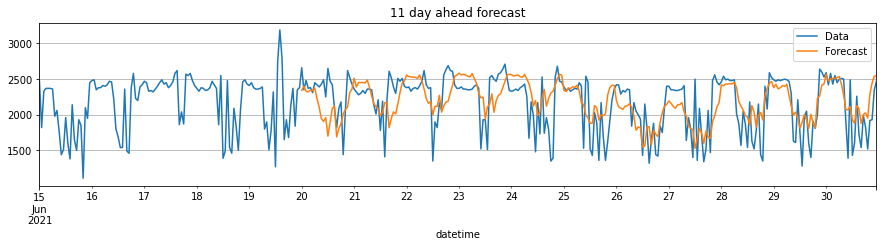

In [8]:
print(f"Advanced {days_ahead} day ahead forecast:")
ground_truth_line = pd.concat([train[-5*24:], test])

predictions = pd.Series(dtype='float64')
for n_day in range(days_ahead):
    cur_timestep = n_day * steps
    next_timestep =  cur_timestep + steps
    day_preds = sarima.forecast(steps)
    predictions = pd.concat([predictions, day_preds])
    y_news = test.iloc[cur_timestep: next_timestep]
    y_news = y_news.asfreq('H')
    sarima = sarima.append(y_news)

predictions.name = test.name
predictions = predictions.rename_axis('datetime')

# Evaluation metrix
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

# Plot the last 5 days of data and the 11 days of forecast
plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

It is obvious that the model fails to capture the fluctuations of the inter-day variance of the load as all spikes (especially downward ones) cannot be forecasted effectively. This is due to the condition of constant variance in ARIMA models.

## SARIMAX for weather variables

In [24]:
weather = pd.read_csv('../VEOLIA/artifacts/weather_curated_60min.csv', index_col=0, parse_dates=True)[datetime(2020, 11, 6):]
weather.head()
exog_training = weather.loc[train.index].values
exog_testing = weather.loc[test.index].values


In [25]:
sarima = sm.tsa.statespace.SARIMAX(endog=train, order=(4, 1, 1), exog=exog_training,
                                   seasonal_order=(1, 1, 1, 24)).fit(max_iter=50, method='powell')
print(sarima.summary())

Optimization terminated successfully.
         Current function value: 7.004750
         Iterations: 11
         Function evaluations: 2369
                                       SARIMAX Results                                        
Dep. Variable:     Diff Load Activa Total (60 minuto)   No. Observations:                 5424
Model:                 SARIMAX(4, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -37993.765
Date:                                Thu, 29 Jul 2021   AIC                          76029.529
Time:                                        16:42:55   BIC                          76168.002
Sample:                                    11-06-2020   HQIC                         76077.874
                                         - 06-19-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

#### Save model locally

In [27]:
# workaround to make pickle work for SARIMAX
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

# storing
fname = "../VEOLIA/models/tal_sarimax.pkl"  
file = open(fname, 'wb')
pickle.dump(sarima, file)
file.close()

### Simple 11-day ahead forecast + weather
Statsmodels does not provide news update with exogenous variables.

In [28]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarimax.forecast(steps * days_ahead, exog=exog_testing)
ground_truth_line = pd.concat([train[-int(days_ahead/2) * 24:], test])

naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(
    15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()


NameError: name 'days_ahead' is not defined